In [1]:
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(8, 8))

In [3]:
adata = sc.read_h5ad('/lorien/pgf/rdata/human_v1/integrated/STEP07.merged.clean_cbn.ann.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 117500 × 30524
    obs: 'sample', 'orig.name', 'study', 'method', 'platform', 'protocol', 'data_process', 'tissue', 'enrichment', 'preparation', 'diagnosis', 'sex_recipient', 'age_recipient', 'sex_donor', 'age_donor', 'duration', 'recipient', 'replicate', 'name', 'name2', 'S.Score', 'G2M.Score', 'Phase', 'nCount_CBN', 'nFeature_CBN', 'pct_mito_CBN', 'nCount_SCT', 'nFeature_SCT', 'pct_mito_SCT', 'Doublet_SC', 'Doublet_SC_score'
    var: '_index', 'features'

In [5]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [6]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample"
)

In [7]:
# run PCA then generate UMAP plots
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [8]:
adata.obsm['X_pcaumap']=adata.obsm['X_umap']

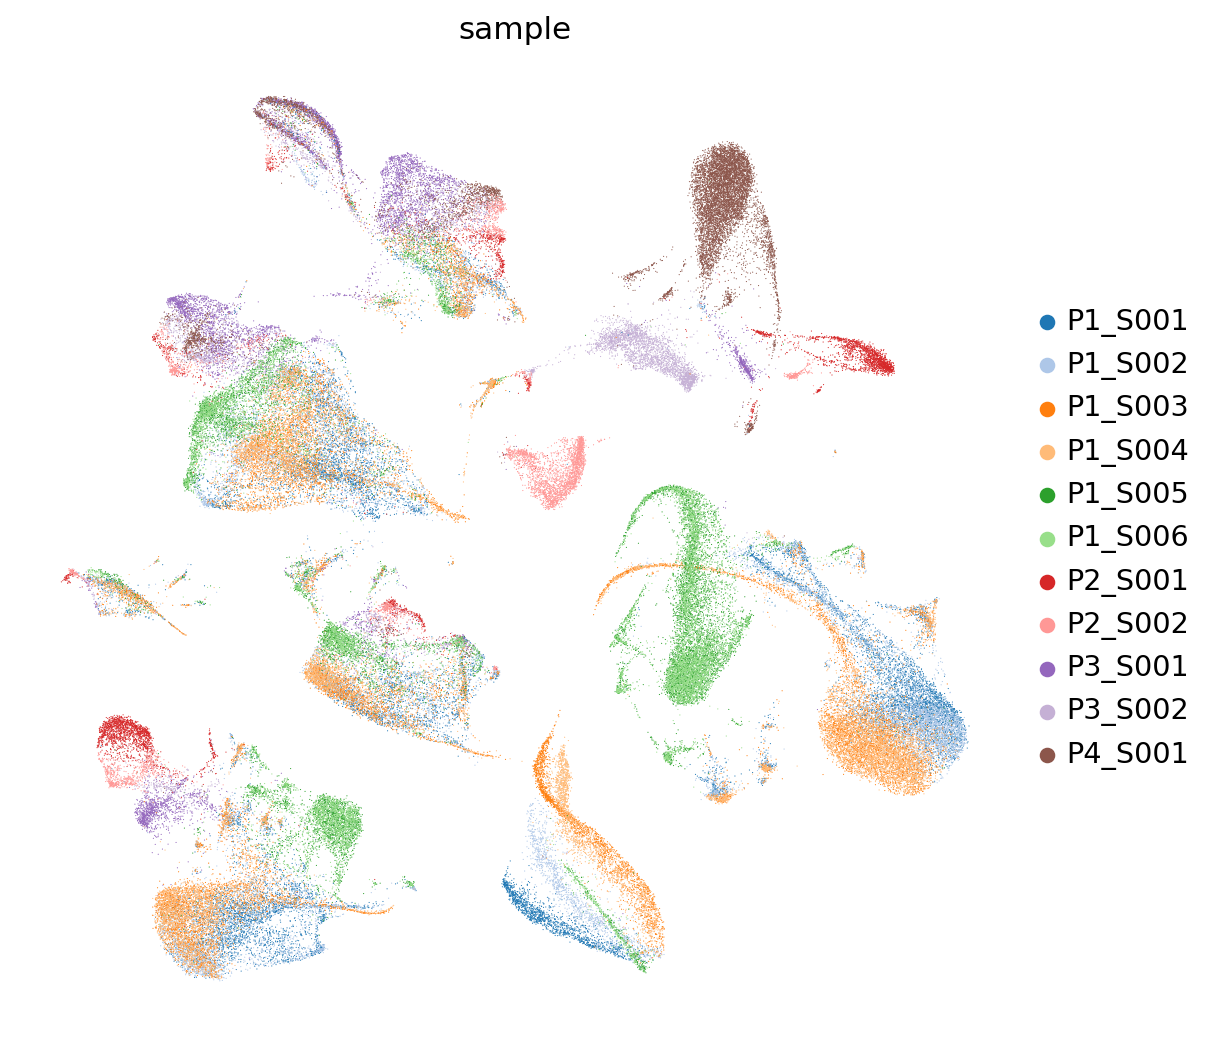

In [9]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_20,
    basis='pcaumap',
    color=["sample"],
    frameon=False,
)

In [10]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key='study',
    categorical_covariate_keys=["sample", 'recipient'],
    continuous_covariate_keys=["pct_mito_CBN", "nCount_CBN", "nFeature_CBN"]
)


In [18]:
## Creating and training a model
model = scvi.model.SCVI(adata)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [20]:
# scvi.data.view_anndata_setup(model.adata)

AttributeError: module 'scvi.data' has no attribute 'view_anndata_setup'

In [21]:
model.train(max_epochs=400)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [1:17:08<00:00, 11.57s/it, loss=797, v_num=1]


In [22]:
## Obtaining model outputs
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

In [23]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
adata.obsm['X_scVIumap']=adata.obsm['X_umap']

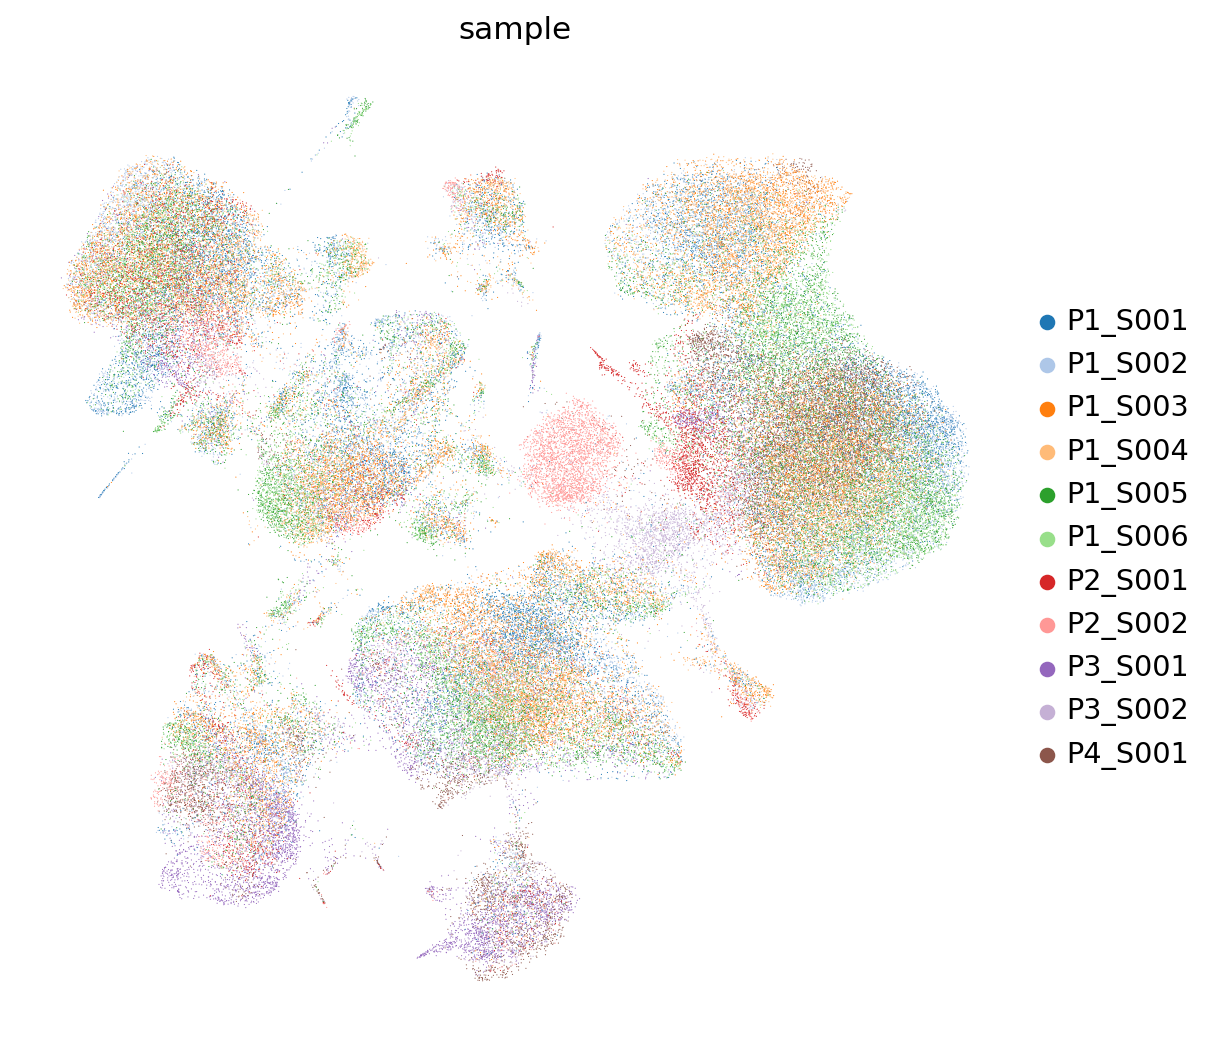

In [24]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_20,
    basis='scVIumap',
    color=["sample"],
    frameon=False,
)

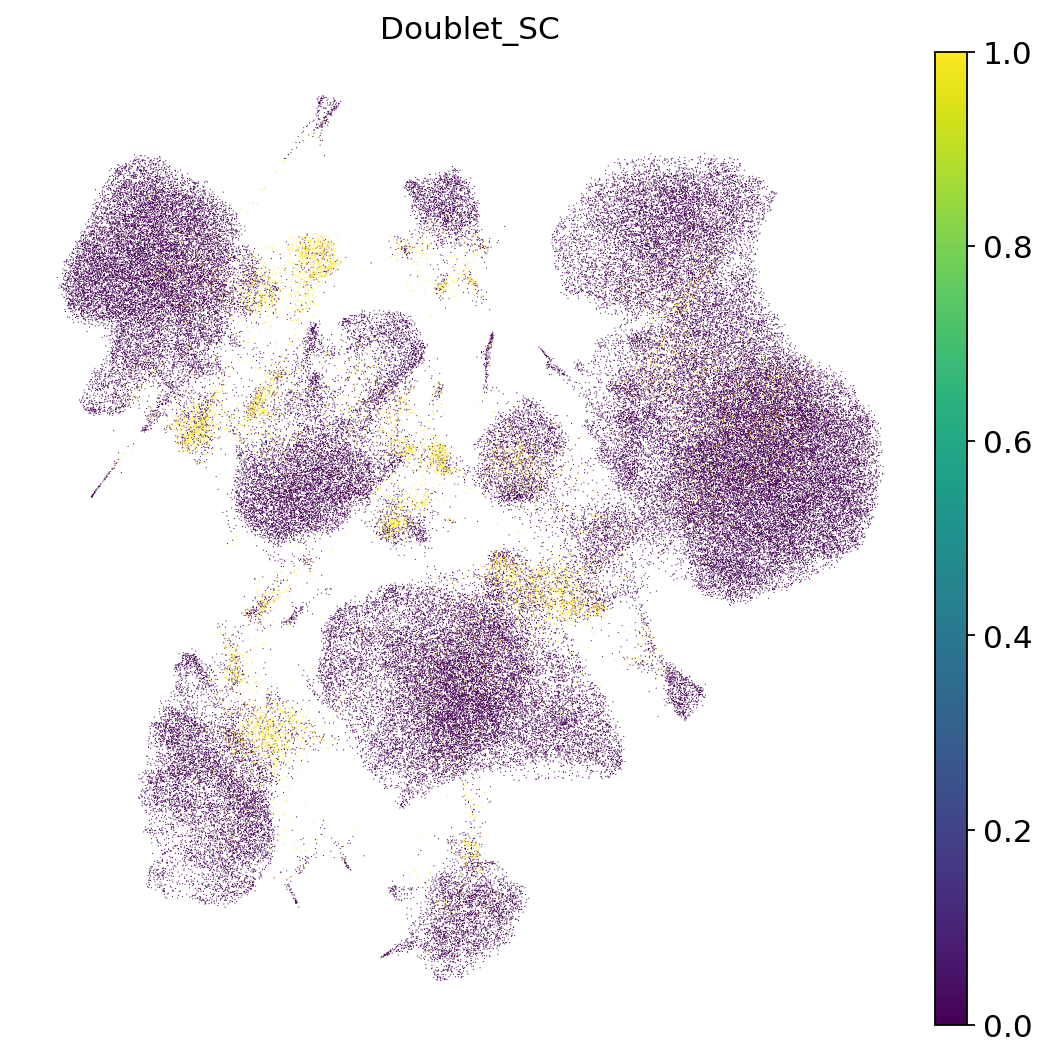

In [25]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_10,
    basis='scVIumap',
    color=["Doublet_SC"],
    frameon=False,
)

In [26]:
model.save("/lorien/pgf/rdata/human_v1/integrated/STEP07.scvi_integration_model")

In [ ]:
# adata.write_h5ad(filename='/moria/peds/rdata/human_v2/integrated/STEP07.scvi_integration.h5ad')

In [ ]:
# adata = sc.read_h5ad('/moria/acute_rejection/rdata/human_v0/integrated/STEP07.scvi_integration.h5ad')

In [27]:
## Clustering the neighborhood graph
sc.tl.leiden(adata, resolution = 1.5, key_added = 'Cluster_leiden_res1.5')
sc.tl.leiden(adata, resolution = 1, key_added = 'Cluster_leiden_res1.0')
sc.tl.leiden(adata, resolution = 0.8, key_added = 'Cluster_leiden_res0.8')
sc.tl.leiden(adata, resolution = 0.5, key_added = 'Cluster_leiden_res0.5')
sc.tl.leiden(adata, resolution = 0.2, key_added = 'Cluster_leiden_res0.2')

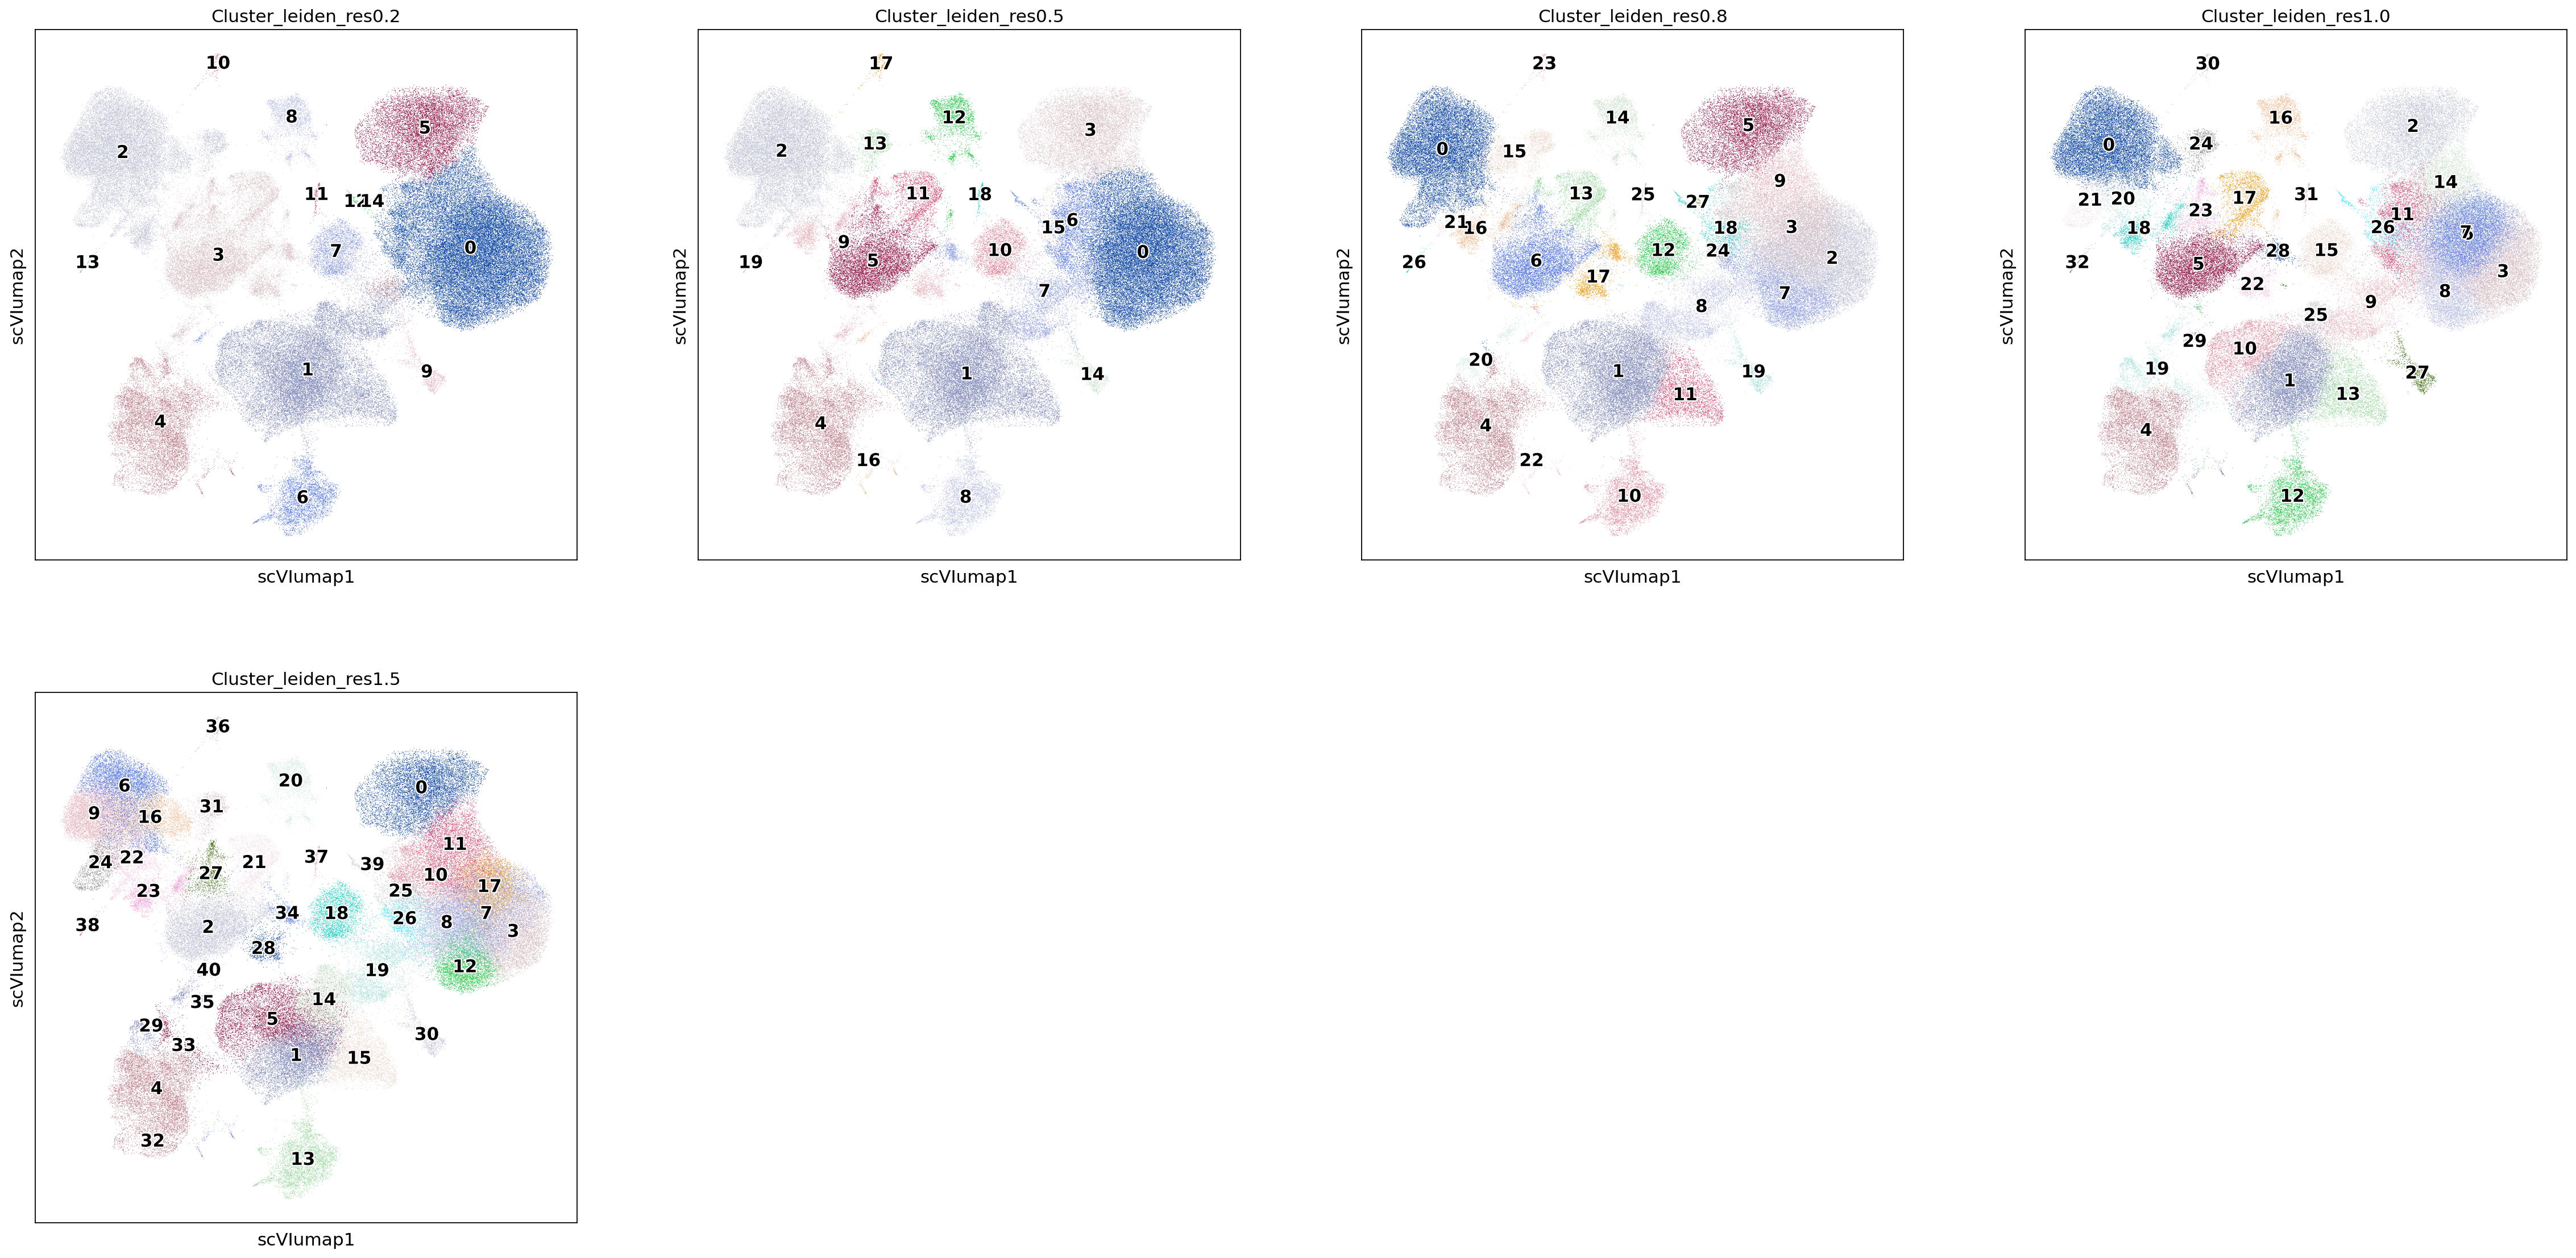

In [28]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.default_28,
    add_outline=False, 
    legend_loc='on data',
    legend_fontoutline=2,
    basis='scVIumap',
    color=['Cluster_leiden_res0.2',
           'Cluster_leiden_res0.5', 
           'Cluster_leiden_res0.8', 
           'Cluster_leiden_res1.0',
           'Cluster_leiden_res1.5']
)

In [29]:
adata

AnnData object with n_obs × n_vars = 117500 × 3000
    obs: 'sample', 'orig.name', 'study', 'method', 'platform', 'protocol', 'data_process', 'tissue', 'enrichment', 'preparation', 'diagnosis', 'sex_recipient', 'age_recipient', 'sex_donor', 'age_donor', 'duration', 'recipient', 'replicate', 'name', 'name2', 'S.Score', 'G2M.Score', 'Phase', 'nCount_CBN', 'nFeature_CBN', 'pct_mito_CBN', 'nCount_SCT', 'nFeature_SCT', 'pct_mito_SCT', 'Doublet_SC', 'Doublet_SC_score', '_scvi_batch', '_scvi_labels', 'Cluster_leiden_res1.5', 'Cluster_leiden_res1.0', 'Cluster_leiden_res0.8', 'Cluster_leiden_res0.5', 'Cluster_leiden_res0.2'
    var: '_index', 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden', 'Cluster_leiden_res0.2_colors', 'Cluster_leiden_res0.5_colors', 'Cluster_leiden_res0.8_colors', 'Cluster_leiden_res1.0_c

In [31]:
adata_bkp = adata

In [54]:
adata.var.rename(columns = {'_index':'XXX'}, inplace = True) ## bug workaround

In [55]:
adata.write_h5ad(filename='/lorien/pgf/rdata/human_v1/integrated/STEP07.scvi_integration.h5ad')